In [1]:
#importing libraries 
import numpy as np
import pandas as pd

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from tqdm import tqdm_notebook as tqdm
from functools import partial
import scipy as sp

import random
import time
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset
from torch.autograd import Variable

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

import warnings
warnings.filterwarnings('ignore')
!mkdir models

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=583b1abfaed2e1b6f823d41982c70547db14533062607f18b6a4ae4fbfecdda8
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
image_size = 256
#IMAGE PREPROCESSING

def prepare_image(path, 
                  sigmaX         = 10, 
                  do_random_crop = False):
    
    '''
    Preprocess image
    '''
    
    # import imagepre
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # perform smart crops
    image = crop_black(image, tol = 7)
    if do_random_crop == True:
        image = random_crop(image, size = (0.9, 1))
    
    # resize and color
    image = cv2.resize(image, (int(image_size), int(image_size)))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
    
    # circular crop
    image = circle_crop(image, sigmaX = sigmaX)

    # convert to tensor    
    image = torch.tensor(image)
    image = image.permute(2, 1, 0)
    return image

In [3]:
#CROP FUNCTIONS

def crop_black(img, 
               tol = 7):
    
    '''
    Perform automatic crop of black areas
    '''
    
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        
        if (check_shape == 0): 
            return img 
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img  = np.stack([img1, img2, img3], axis = -1)
            return img

In [4]:
def circle_crop(img, 
                sigmaX = 10):   
    
    '''
    Perform circular crop around image center
    '''
        
    height, width, depth = img.shape
    
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape
    
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness = -1)
    
    img = cv2.bitwise_and(img, img, mask = circle_img)
    return img

In [5]:
def random_crop(img, 
                size = (0.9, 1)):
    
    '''
    Random crop
    '''

    height, width, depth = img.shape
    
    cut = 1 - random.uniform(size[0], size[1])
    
    i = random.randint(0, int(cut * height))
    j = random.randint(0, int(cut * width))
    h = i + int((1 - cut) * height)
    w = j + int((1 - cut) * width)

    img = img[i:h, j:w, :]    
    
    return img

In [6]:
class EyeData(Dataset):
    
    # initialize
    def __init__(self, data, directory, transform = None, do_random_crop = True, itype = '.jpeg'):
        self.data      = data
        self.directory = directory
        self.transform = transform
        self.do_random_crop = do_random_crop
        self.itype = itype
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'image'] + self.itype)
        image    = prepare_image(img_name, do_random_crop = self.do_random_crop)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'level'])
        return {'image': image, 'label': label}

In [7]:
class Data(Dataset):
    
    # initialize
    def __init__(self, data, directory, transform = None, do_random_crop = True, itype = '.jpeg'):
        self.data      = data
        self.directory = directory
        self.transform = transform
        self.do_random_crop = do_random_crop
        self.itype = itype
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'image'] + self.itype)
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = crop_black(image, tol = 7)
        image = cv2.resize(image, (int(image_size), int(image_size)))
        image = circle_crop(image, sigmaX = 10)
        image = torch.tensor(image)
        image = image.permute(2, 1, 0)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'level'])
        return {'image': image, 'label': label}

In [9]:
df = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
train.columns = ['image', 'level']
train = df[:28000]
test  = df[28000:]

# check shape
print(train.shape, test.shape)
print('-' * 15)
print(train['level'].value_counts())
print('-' * 15)
print(test['level'].value_counts())

(28000, 2) (7126, 2)
---------------
level
0    20528
2     4256
1     1955
3      706
4      555
Name: count, dtype: int64
---------------
level
0    5282
2    1036
1     488
3     167
4     153
Name: count, dtype: int64


In [ ]:
# CLASS DISTRIBUTION

# plot
fig = plt.figure(figsize = (15, 5))
plt.hist(train['level'])
plt.title('Class Distribution')
plt.ylabel('Number of examples')
plt.xlabel('Diagnosis')

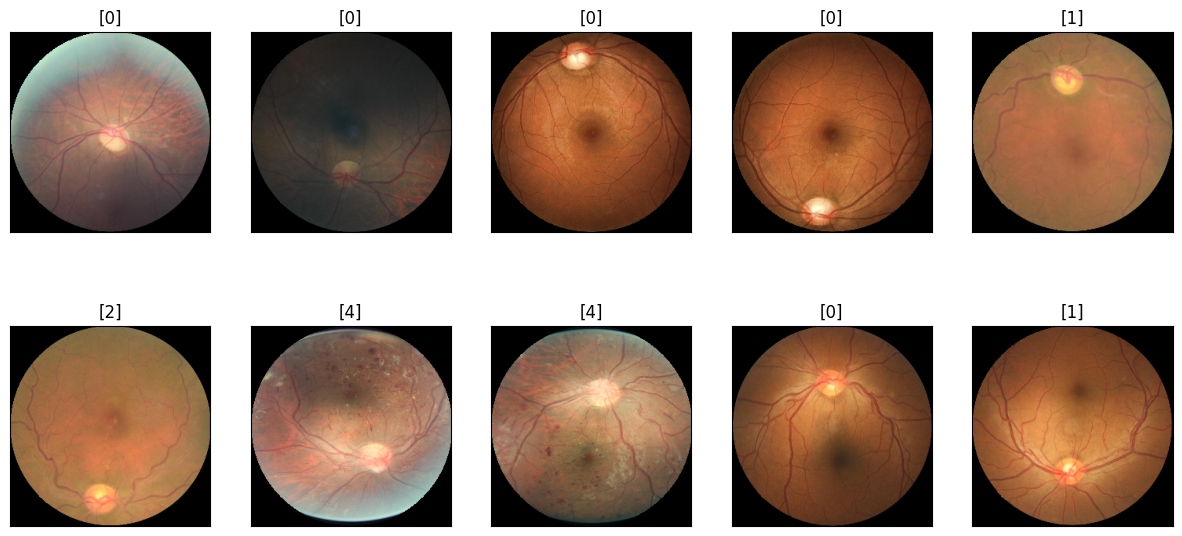

In [10]:
# transformations
sample_trans = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                  ])
sample = Data(data       = train.iloc[0:10], 
                      directory  = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                      transform  = sample_trans,
                      itype ='.jpeg')

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = 10, 
                                            shuffle     = False, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (15, 7))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, int(len(labels)/2), i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

In [11]:
# IMAGE SIZES

# placeholder
image_stats = []

# import loop
for index, observation in tqdm(train.iterrows(), total = len(train)):
    
    # import image
    img = cv2.imread('../input/diabetic-retinopathy-resized/resized_train/resized_train/{}.jpeg'.format(observation['image']))

    # compute stats
    height, width, channels = img.shape
    ratio = width / height
    
    # save
    image_stats.append(np.array((observation['level'], height, width, channels, ratio)))

# construct DF
image_stats = pd.DataFrame(image_stats)
image_stats.columns = ['level', 'height', 'width', 'channels', 'ratio']

  0%|          | 0/28000 [00:00<?, ?it/s]

In [ ]:
# IMAGE SIZE DISTRIBUTION

fig = plt.figure(figsize = (15, 5))

# width
plt.subplot(1, 3, 1)
plt.hist(image_stats['width'])
plt.title('(a) Image Width')
plt.ylabel('Number of examples')
plt.xlabel('Width')

# height
plt.subplot(1, 3, 2)
plt.hist(image_stats['height'])
plt.title('(b) Image Height')
plt.ylabel('Number of examples')
plt.xlabel('Height')

# ratio
plt.subplot(1, 3, 3)
plt.hist(image_stats['ratio'])
plt.title('(c) Aspect Ratio')
plt.ylabel('Number of examples')
plt.xlabel('Ratio')

In [12]:
#TRANSFORMATIONS

# parameters
batch_size = 16
image_size = 256

# train transformations
train_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomRotation((-360, 360)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor()
                                 ])

# validation transformations
valid_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                 ])

# test transformations
test_trans = valid_trans

In [ ]:
#EXAMINE FIRST BATCH (TRAIN)

# get dataset
sample = EyeData(data       = train.iloc[0:10], 
                      directory  = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                      transform  = train_trans,
                      itype ='.jpeg')

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = batch_size, 
                                            shuffle     = True, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (20,10))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, int(len(labels)/2), i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

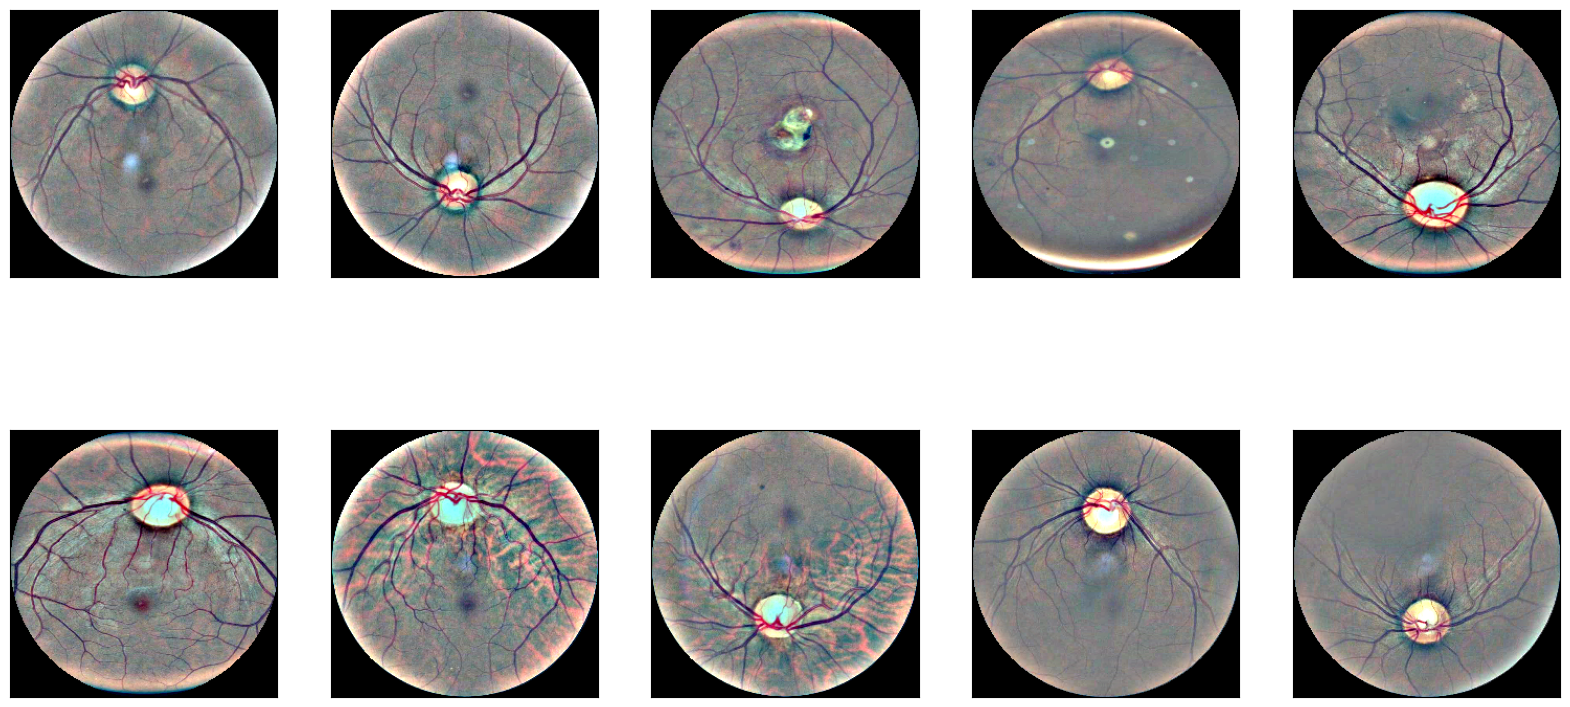

In [13]:
#EXAMINE FIRST BATCH (TEST)
test = test.reset_index()
# get dataset
sample = EyeData(data       = test.iloc[0:10], 
                      directory  = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                      transform  = test_trans,
                      itype ='.jpeg',
                      do_random_crop = False)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = batch_size, 
                                            shuffle     = False, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
 
    # create plot
    fig = plt.figure(figsize = (20,10))
    for i in range(10):
        ax = fig.add_subplot(2, int(10/2), i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))

    break